# Power analysis studies
In this notebook I will try to fill the gap in my understanding of the power analysis with pratical experiments using the **Chipwhisperer**

In [1]:
%matplotlib notebook

import time
import subprocess
from pathlib import Path
import numpy as np
import matplotlib.pylab as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from tqdm.notebook import trange
import chipwhisperer as cw

    
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEXMEGA'
PATH_CW = Path('/opt/ChipWhisperer-git/')

def cw_init():
    global SCOPETYPE
    global PLATFORM

    try:
        if not scope.connectStatus:
            scope.con()
    except NameError:
        scope = cw.scope()

    try:
        target = cw.target(scope)
    except IOError:
        print("INFO: Caught exception on reconnecting to target - attempting to reconnect to scope first.")
        print("INFO: This is a work-around when USB has died without Python knowing. Ignore errors above this line.")
        scope = cw.scope()
        target = cw.target(scope)

    print("INFO: Found ChipWhisperer😍")
    
    time.sleep(0.05)
    scope.default_setup()
    
    scope.adc.samples = 300
    scope.adc.timeout = 5000
    
    print(scope)
    
    prog = cw.programmers.XMEGAProgrammer
    
    return scope, target, prog

In [51]:
# use this to restart the Chipwhisperer
scope, target, prog = cw_init()

See https://chipwhisperer.readthedocs.io/en/latest/api.html#firmware-update


INFO: Found ChipWhisperer😍
cwlite Device
sn         = 4420312046304a383030312034313032
fw_version = 
    major = 0
    minor = 20
    debug = 0
gain = 
    mode = high
    gain = 30
    db   = 24.8359375
adc = 
    state          = False
    basic_mode     = rising_edge
    timeout        = 5000
    offset         = 0
    presamples     = 0
    samples        = 300
    decimate       = 1
    trig_count     = 7373321
    fifo_fill_mode = normal
clock = 
    adc_src       = clkgen_x4
    adc_phase     = 0
    adc_freq      = 0
    adc_rate      = 0.0
    adc_locked    = True
    freq_ctr      = 0
    freq_ctr_src  = extclk
    clkgen_src    = system
    extclk_freq   = 10000000
    clkgen_mul    = 2
    clkgen_div    = 26
    clkgen_freq   = 7384615.384615385
    clkgen_locked = True
trigger = 
    triggers = tio4
    module   = basic
io = 
    tio1         = serial_rx
    tio2         = serial_tx
    tio3         = high_z
    tio4         = high_z
    pdid         = high_z
    pdic     

In [3]:
path_fw = PATH_CW / "hardware/victims/firmware/simpleserial-power/simpleserial-power-{}.hex".format(PLATFORM)

In [4]:
def reset_target(scope):
    scope.io.pdic = False
    time.sleep(0.1)
    scope.io.pdic = 'high_z' #XMEGA doesn't like pdic driven high
    time.sleep(0.1) #xmega needs more startup time


In [5]:
def firmware_compile(options):
    p = subprocess.run(
        'cp -rv simpleserial-power {path_cw}/hardware/victims/firmware/ && cd {path_cw}/hardware/victims/firmware/simpleserial-power && LANG=C make PLATFORM={platform} {options} CRYPTO_TARGET=NONE'.format(
            platform=PLATFORM, path_cw=PATH_CW, options=options,
        ),
        capture_output=True,
        shell=True)
    #print(p.stdout.decode('utf-8')[:-100])
    print(p.stderr.decode('utf-8'))
    p.check_returncode()

In [6]:
def upload():
    cw.program_target(
        scope,
        prog,
        str(path_fw))

In [7]:
def firmware_disassembly(fw, name_function):
    fw = str(fw)[:-3] + "elf"
    p = subprocess.run(
        "avr-objdump  -D --disassemble-zeroes {fw} | sed -n '/<{name}>:/,/^$/p'".format(fw=fw, name=name_function),
        capture_output=True,
        shell=True)
    stdout = p.stdout.decode('utf-8')
    
    print(stdout)
    print(p.stderr.decode('utf-8'))
    
    return stdout

In [8]:
def capture_trace(scope):
    # remember to reset
    reset_target(scope)
    # and then arm otherwise
    # the scope will trigger
    # during the reset itself
    scope.arm()

    is_captured = not scope.capture()
    
    if not is_captured:
        return None

    return scope.get_last_trace()

In [9]:
def normalize_trace(trace):
    """The values coming from the ADC must be inverted"""
    return -trace

In [10]:
def plot_traces(traces: list, xlim=None):
    plt.figure(figsize=(8, 8))
    ax = plt.axes()
    ax.xaxis.set_major_locator(MultipleLocator(40))
    ax.xaxis.set_minor_locator(AutoMinorLocator(10))

    # plt.minorticks_on()

    plt.grid()
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

    for trace, color, label in traces:
        trace_normalized = normalize_trace(trace)
        plt.plot(trace_normalized, color=color, label=label)
        
        if xlim is not None:
            plt.xlim(*xlim)
    plt.legend()

    plt.show()

In [11]:
def plot_traces_by_side(traces: list):
    N = len(traces)
    
    fig = plt.figure(figsize=(8,3*N))

    for idx, (trace, color, label) in enumerate(traces):
        trace_normalized = normalize_trace(trace)
    
        ax = plt.subplot(N, 1, idx + 1)
        ax.xaxis.set_major_locator(MultipleLocator(40))
        ax.xaxis.set_minor_locator(AutoMinorLocator(10))
        plt.plot(trace_normalized, color=color, label=label)

        ax.grid()
        ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
        ax.legend()


    #fig.tight_layout()
    plt.show()

In [12]:
def capture_and_plot(scope, color, label):
    trace = capture_trace(scope)

    plot_traces([(trace, color, label)])
    
    return trace

In [13]:
def do(options, color, label):
    print('### {}'.format(label.upper()))
    firmware_compile(options)
    upload()
    firmware_disassembly(path_fw, "main")
    return capture_and_plot(scope, color, label)

### EMPTY

XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1783 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40       	sbc

<IPython.core.display.Javascript object>


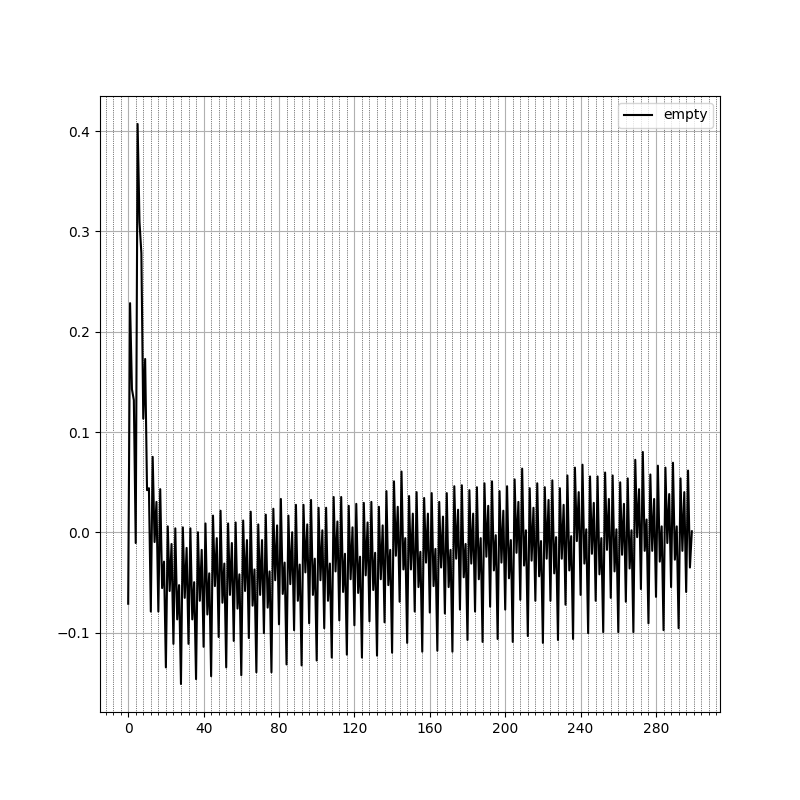

In [14]:
trace_empty = do("", 'black', 'empty')

### NOP

XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1803 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40       	sbci	

<IPython.core.display.Javascript object>


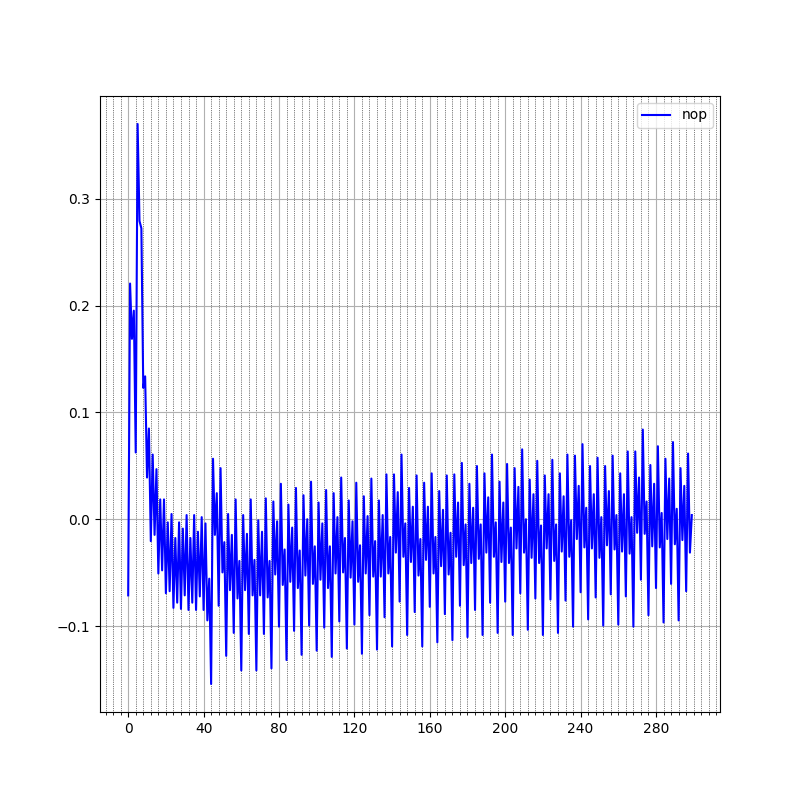

### MUL

XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1803 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40       	sbci	

<IPython.core.display.Javascript object>


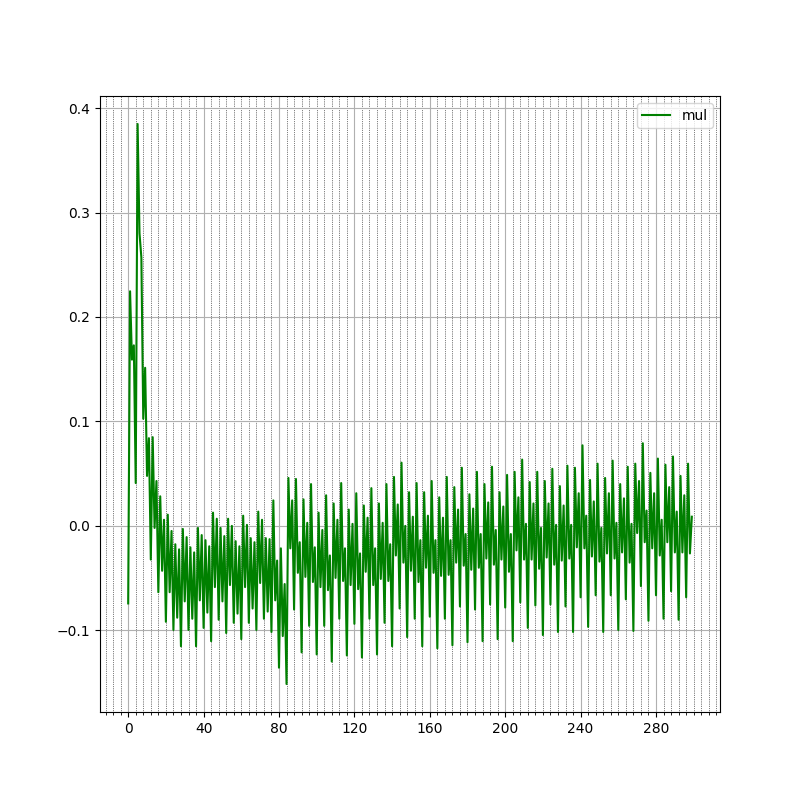

### MUL+MUL

XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1823 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40       	s

<IPython.core.display.Javascript object>


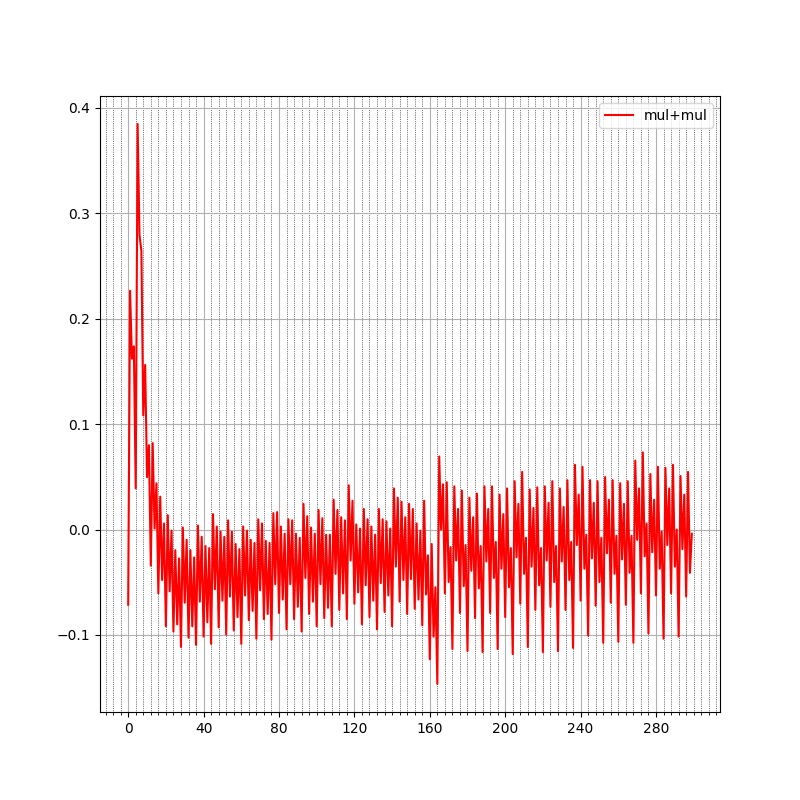

### MUL+NOP+MUL

XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1843 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40     

<IPython.core.display.Javascript object>


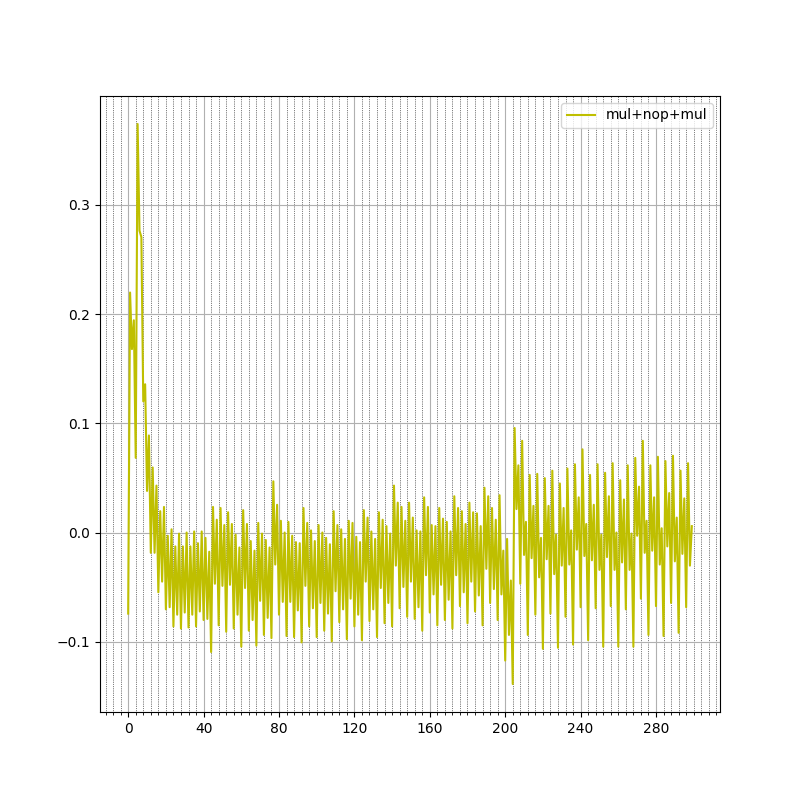

### ZERO

XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1845 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40       	sbci

<IPython.core.display.Javascript object>


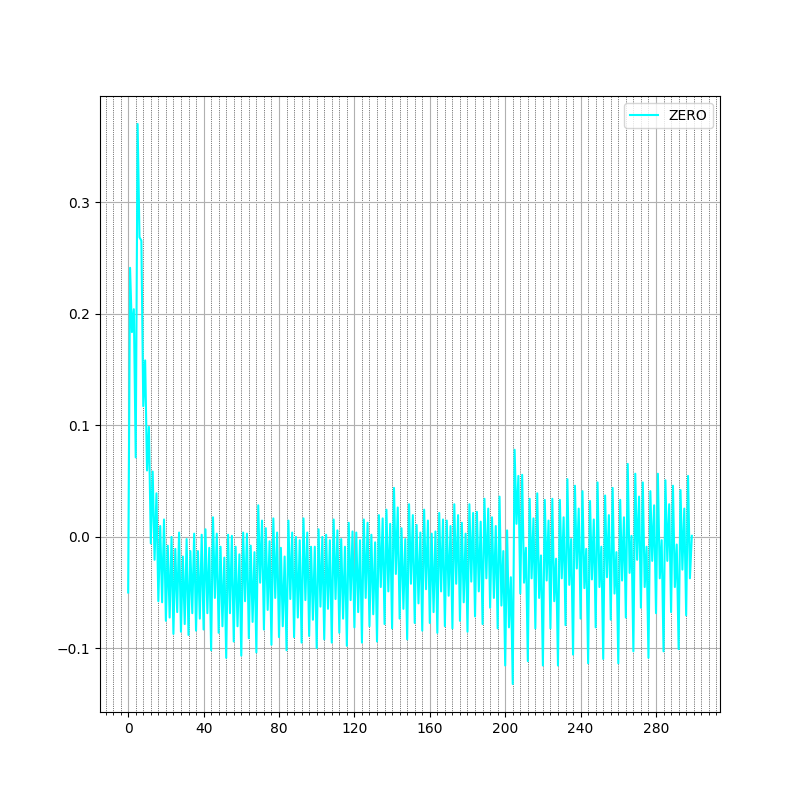

### FF

XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1847 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40       	sbci	r

<IPython.core.display.Javascript object>


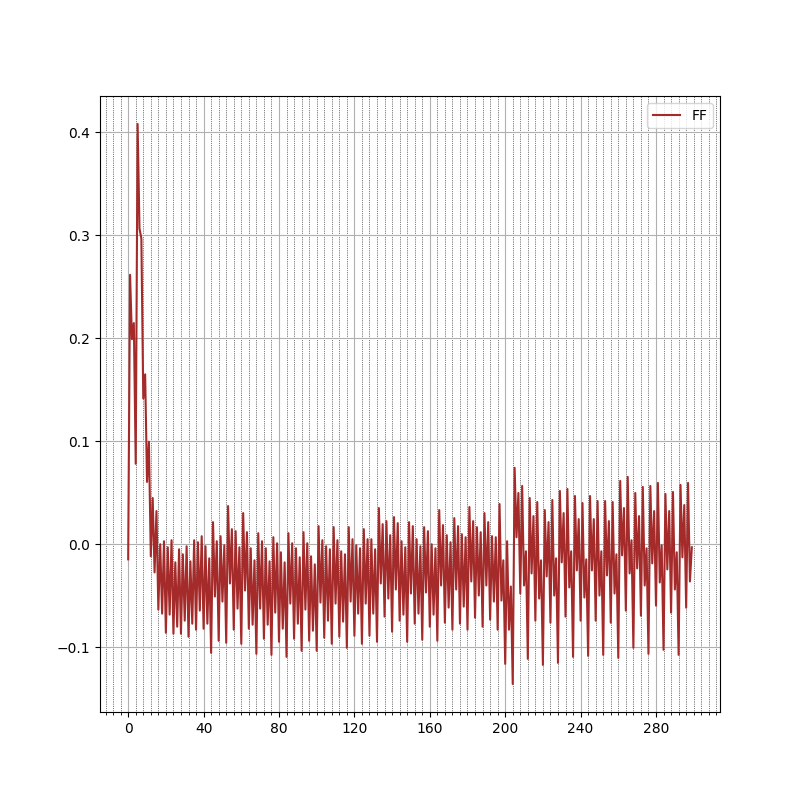

In [15]:
trace_nop = do("NOP=1", 'b', 'nop')
trace_mul = do("MUL=1", 'g', 'mul')
trace_mul2 = do("MUL=1 MUL2=1", 'r', 'mul+mul')
trace_mul_nop_mul = do("MUL=1 MUL2=1 NOP=1", 'y', 'mul+nop+mul')
trace_mul_zero = do("NOP=1 MUL=1 MUL2=1 SET_ZERO=1", 'cyan', 'ZERO')
trace_mul_ff = do("NOP=1 MUL=1 MUL2=1 SET_FF=1", 'brown', 'FF')

<IPython.core.display.Javascript object>


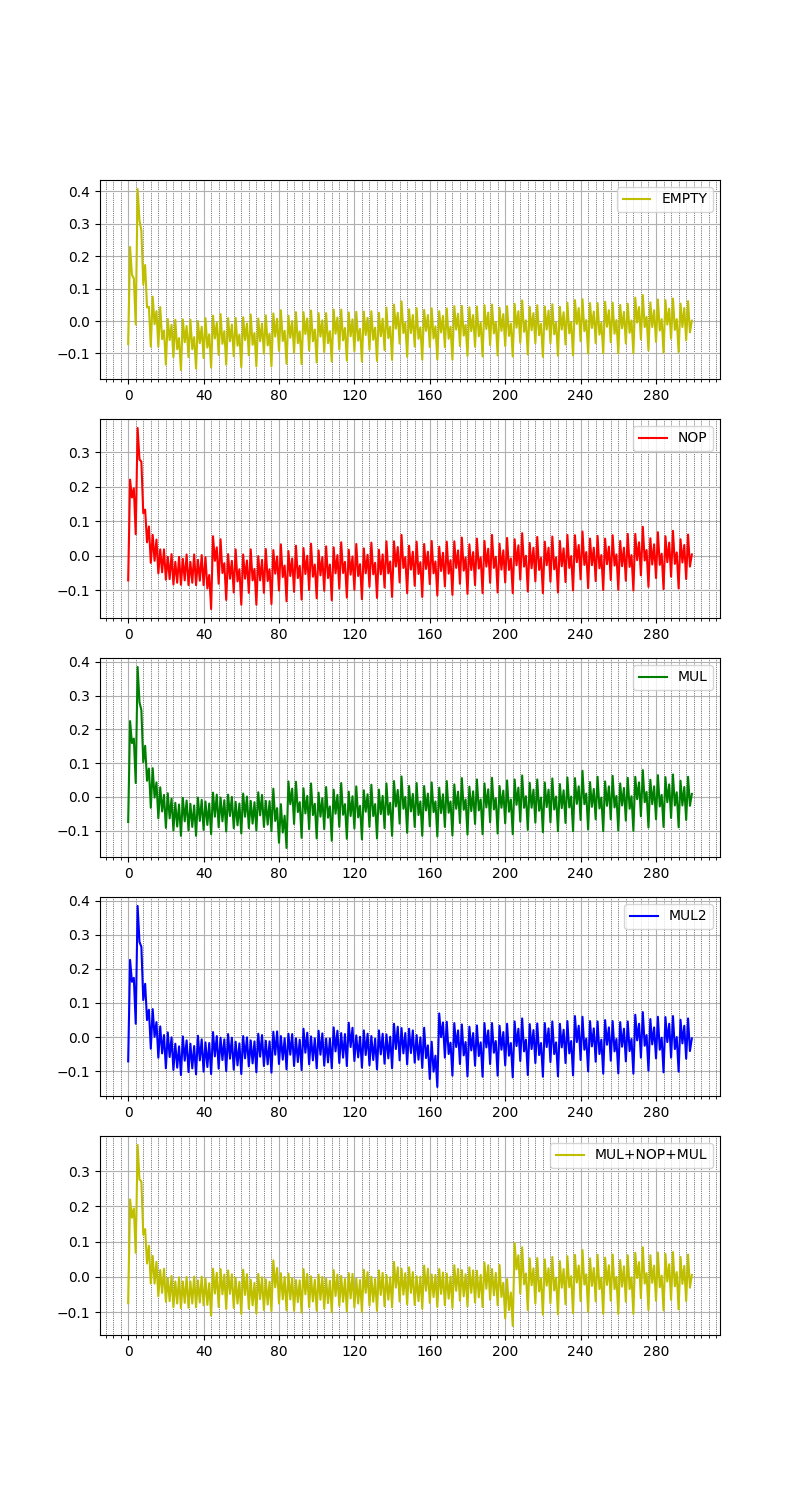

In [16]:
plot_traces_by_side([
    (trace_empty, 'y', 'EMPTY'),
    (trace_nop, 'r', 'NOP'),
    (trace_mul, 'g', 'MUL'),
    (trace_mul2, 'b', 'MUL2'),
    (trace_mul_nop_mul, 'y', 'MUL+NOP+MUL'),
    #(trace_mul_zero, 'black', 'MUL BY ZERO'),
    #(trace_mul_ff, 'brown', 'MUL BY FF'),
])

<IPython.core.display.Javascript object>


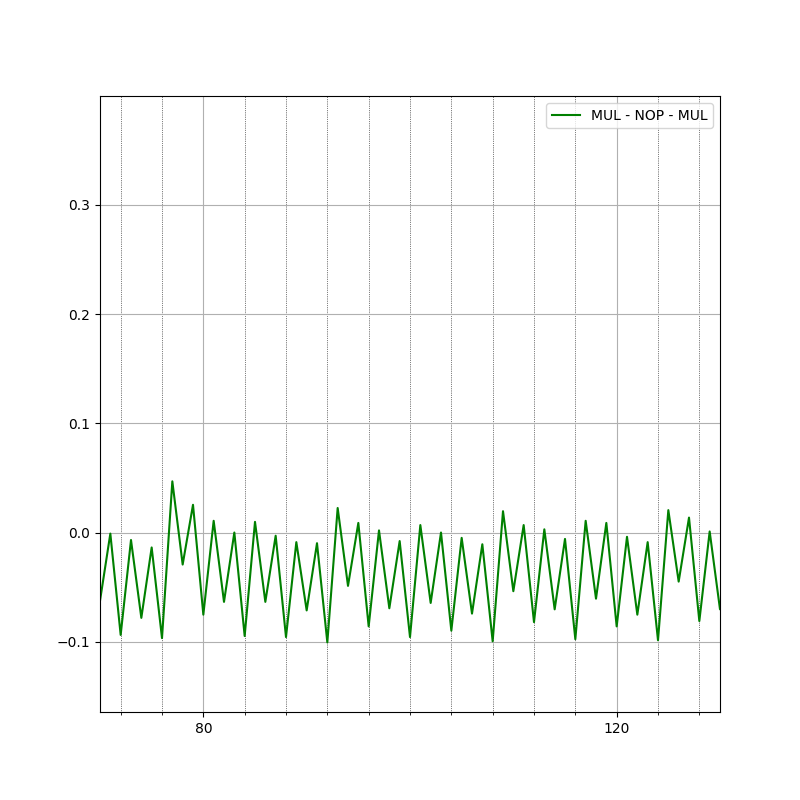

In [17]:
plot_traces([
    (trace_mul_nop_mul, 'g', 'MUL - NOP - MUL'),
], xlim=[70, 130])

<IPython.core.display.Javascript object>


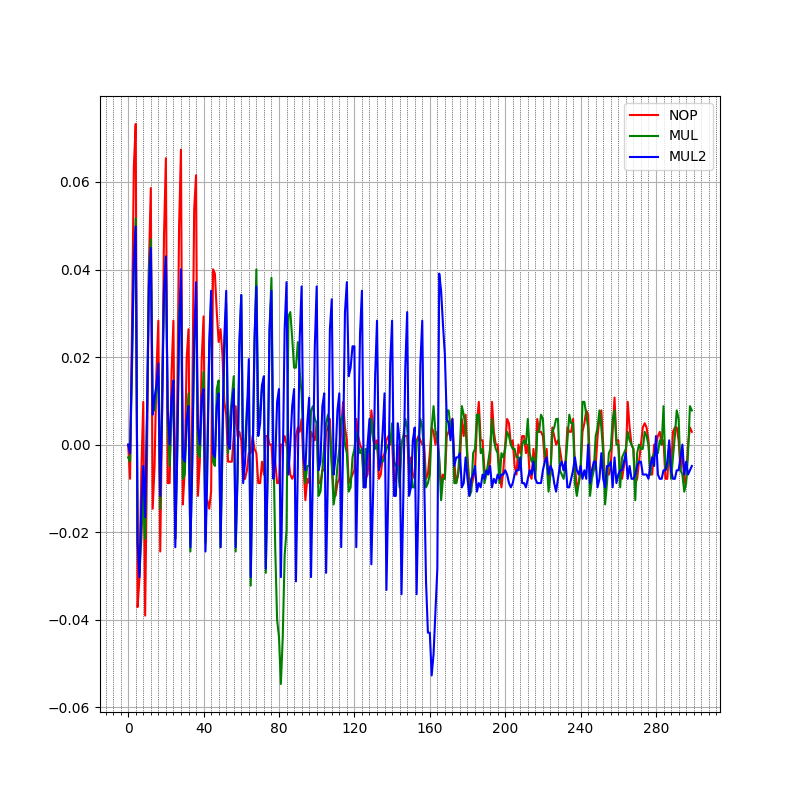

<IPython.core.display.Javascript object>


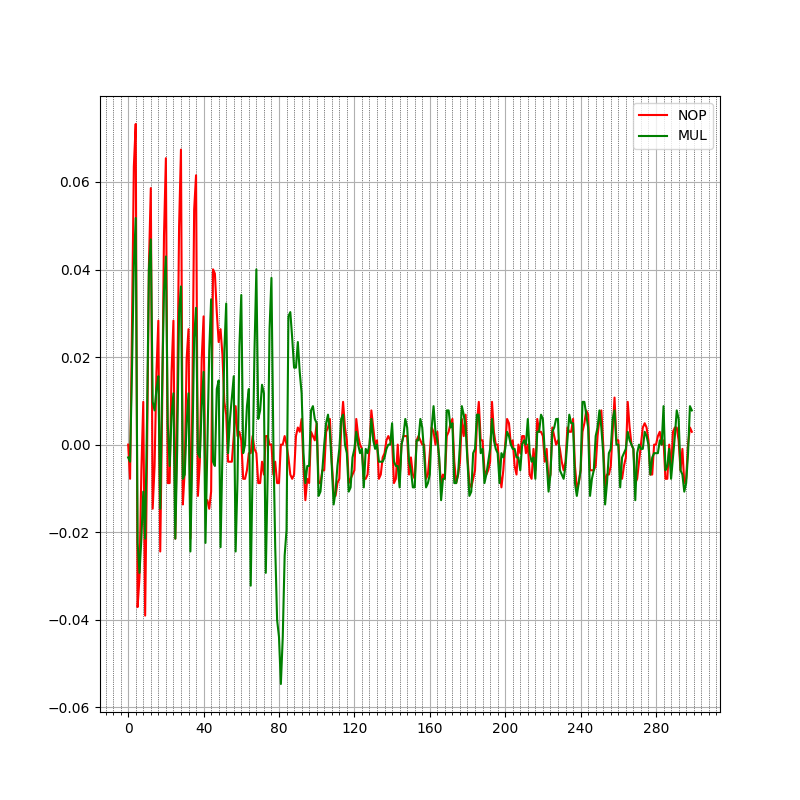

<IPython.core.display.Javascript object>


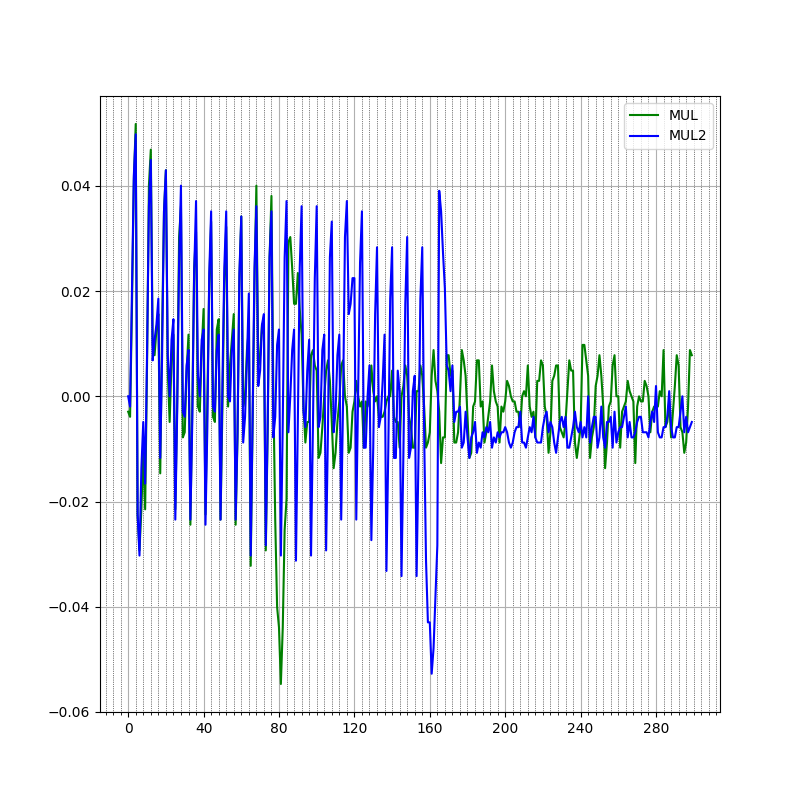

<IPython.core.display.Javascript object>


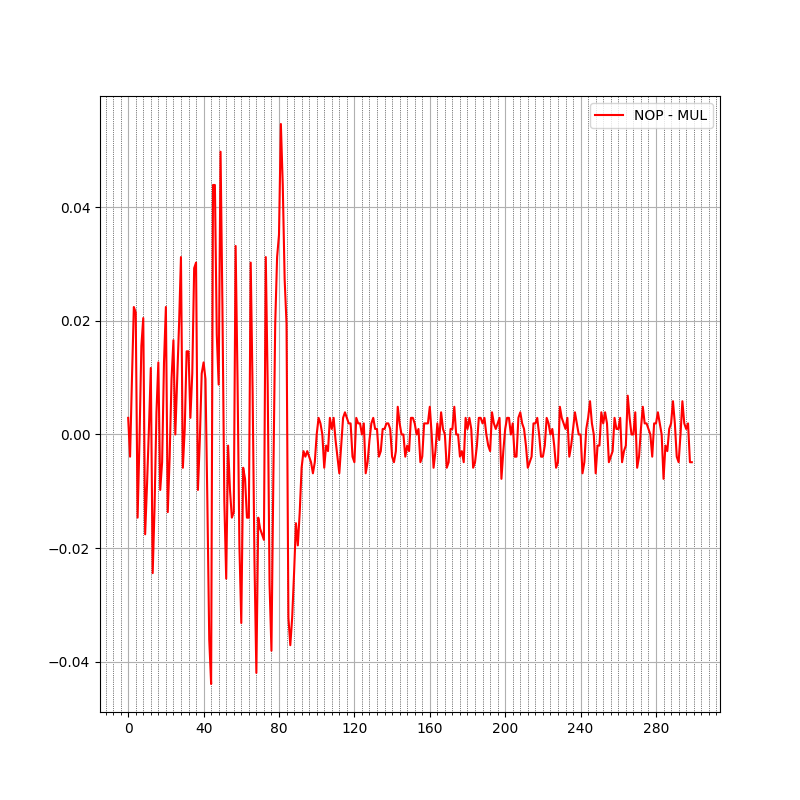

<IPython.core.display.Javascript object>


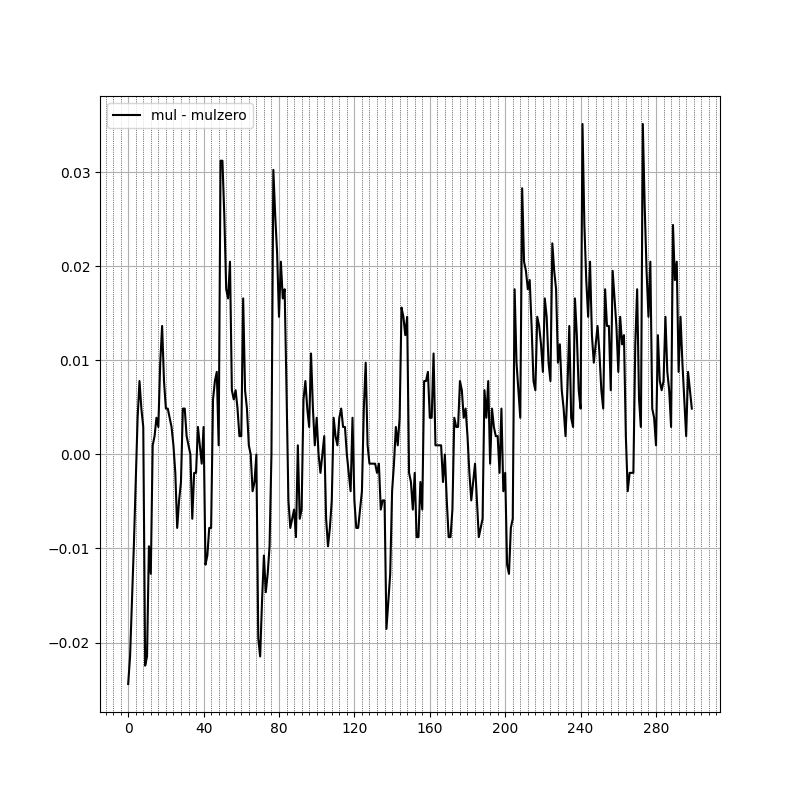

<IPython.core.display.Javascript object>


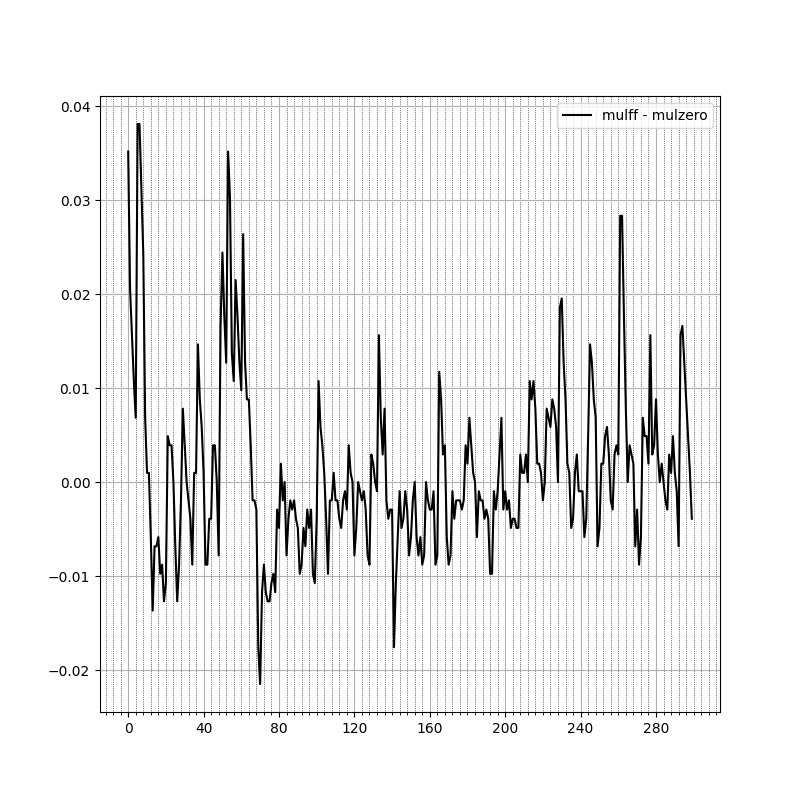

<IPython.core.display.Javascript object>


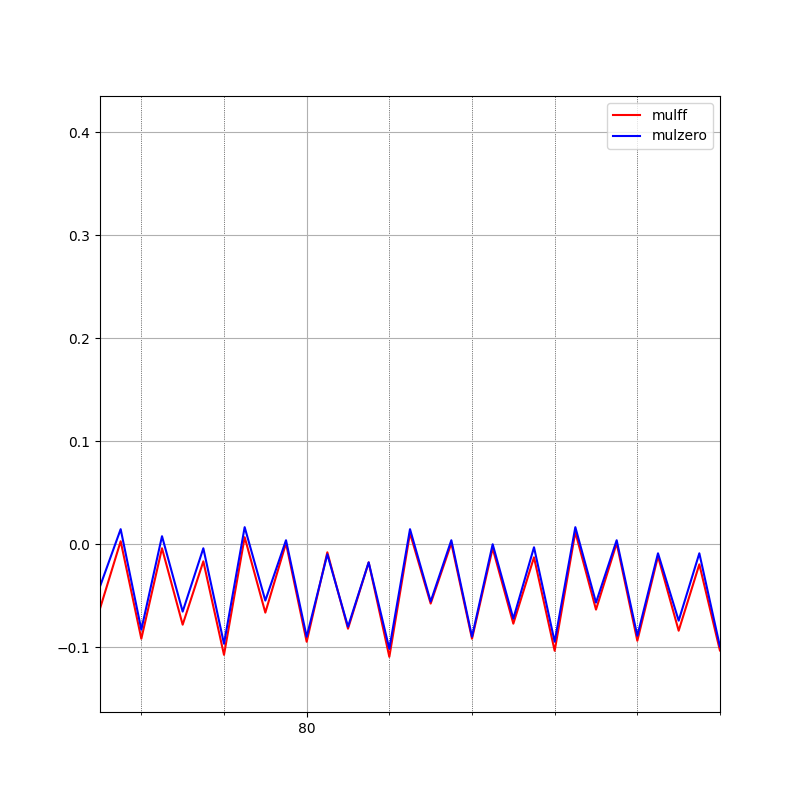

In [18]:
plot_traces([
    (trace_nop - trace_empty, 'r', 'NOP'),
    (trace_mul - trace_empty, 'g', 'MUL'),
    (trace_mul2 - trace_empty, 'b', 'MUL2'),
])
plot_traces([
    (trace_nop - trace_empty, 'r', 'NOP'),
    (trace_mul - trace_empty, 'g', 'MUL'),
])
plot_traces([
    (trace_mul - trace_empty, 'g', 'MUL'),
    (trace_mul2 - trace_empty, 'b', 'MUL2'),
])
plot_traces([
    (trace_nop - trace_mul, 'r', 'NOP - MUL'),
])
plot_traces([
    (trace_mul_nop_mul - trace_mul_zero, 'black', 'mul - mulzero')
])
plot_traces([
    (trace_mul_ff - trace_mul_zero, 'black', 'mulff - mulzero')
])
plot_traces([
    (trace_mul_ff, 'red', 'mulff'),
    (trace_mul_zero, 'blue', 'mulzero')
], xlim=[70, 100])

In [19]:
def stats_from_traces(traces):
    trace_mean = np.mean(traces, axis=0)
    trace_std = np.std(traces, axis=0)
    trace_max = np.max(traces, axis=0)
    trace_min = np.min(traces, axis=0)
    
    return np.array((trace_mean, trace_std, trace_min, trace_max))

In [20]:
def analyze(options, count=500):
    """Capture and analyze `count` traces.
    
    It also saves locally the traces in the"""
    print(options)
    firmware_compile(options)
    upload()
    disassembly = firmware_disassembly(path_fw, 'main')
    
    traces = []
    for _ in trange(count):
        trace = capture_trace(scope)
        
        if trace is None:
            print("trace not captured")
            continue
        
        traces.append(normalize_trace(trace))
        
    return np.array((np.array(traces), stats_from_traces(traces), disassembly))

In [22]:
def capture_hamming(options_hamming, count=100):
    """Capture `count` traces for hamming weight using `options_hamming`
    to pass the compiler options along the way.
    
    An example is the following
    
    options_hamming = {
        0: 'NOP=1 LDI_AFTER_JMP=0',
        1: 'NOP=1 LDI_AFTER_JMP=1',
        2: 'NOP=1 LDI_AFTER_JMP=3',
        3: 'NOP=1 LDI_AFTER_JMP=7',
        4: 'NOP=1 LDI_AFTER_JMP=15',
        5: 'NOP=1 LDI_AFTER_JMP=31',
        6: 'NOP=1 LDI_AFTER_JMP=63',
        7: 'NOP=1 LDI_AFTER_JMP=127',
        8: 'NOP=1 LDI_AFTER_JMP=255',
    }
    """

    traces_hamming = {}

    for weight, options in options_hamming.items():
        traces_hamming[weight] = analyze(options, count=count)

    # here we have the traces in a dictionary organized in the following
    #  - outer key the hamming weight
    #  - each key contains a tuple (traces, stats, disassembly)
    return traces_hamming

Now I factorize some code in order to create a class for capturing sessions

In [21]:
import os
import sys
import logging

logging.basicConfig(
    format='%(asctime)s [%(levelname)s] %(name)s - %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
    stream=sys.stdout,
)



class Session:
    PATH_SESSIONS = "sessions"
    """Encapsulate the data of a capture session.
    
    The sessions are saved into the directory `sessions/`.
    
    >>> s = Session('ldi')
    >>> s.capture({_: 'NOP=1 LDI=%d' % ((1 << _) - 1) for _ in range(9)})
    """
    def __init__(self, name: str, options: dict):
        self.name = self.slugify(name)
        self.options_hamming = options
        
        self.logger = logging.getLogger(self.__class__.__name__)
        self.logger.setLevel('INFO')
        
    @staticmethod
    def slugify(label: str):
        return label.translate(str.maketrans("/ ;", "___"))
        
    @classmethod
    def get_sessions(cls):
        """Return the previous sessions"""
        if not os.path.exists(cls.PATH_SESSIONS):
            raise Exception("you must create the `sessions` directory")
            
        dirpath, dirnames, filenames = next(os.walk(cls.PATH_SESSIONS))
        return dirnames
    
    def get_path(self):
        return '{}.npy'.format(os.path.join(self.PATH_SESSIONS, self.name))
    
    def get_trace(self):
        """Try to retrieve traces for this session from the filesystem."""
        path = self.get_path()
        
        if not os.path.exists(path):
            return None
        
        self.logger.info("loading trace found at '{}'".format(path))
        
        return np.load(path, allow_pickle=True)[()]
    
    def save_trace(self, data):
        path = self.get_path()
        self.logger.info("saving data at '{}'".format(path))
        np.save(path, data)
    
    def stats_from_traces(self, traces):
        trace_mean = np.mean(traces, axis=0)
        trace_std = np.std(traces, axis=0)
        trace_max = np.max(traces, axis=0)
        trace_min = np.min(traces, axis=0)

        return np.array((trace_mean, trace_std, trace_min, trace_max))

    def do_single_capture(self, label, options, count=100):
        """TODO: rename this function to mirror the fact that this
        doesn't capture one trace but capture maintaining fixed
        the firmware on the device."""
            
        self.logger.debug(options)
        firmware_compile(options)
        upload()
        disassembly = firmware_disassembly(path_fw, 'main')

        traces = []
        for _ in trange(count):
            trace = capture_trace(scope)

            if trace is None:
                self.logger.warning("trace not captured")
                continue

            traces.append(normalize_trace(trace))
            
        result = np.array((np.array(traces), stats_from_traces(traces), disassembly))
        
        return result
    
    def capture(self, count=100):
        """Capture `count` traces"""
        
        cache = self.get_trace()
        
        if cache is not None:
            self.logger.info('using cache')
            return cache

        traces_hamming = {}

        for weight, options in self.options_hamming.items():
            traces_hamming[weight] = self.do_single_capture(self.name, options, count=count)

        # here we have the traces in a dictionary organized in the following
        #  - outer key the hamming weight
        #  - each key contains a tuple (traces, stats, disassembly)
        
        self.save_trace(traces_hamming)

        return traces_hamming
    

In [32]:
analysis_for_nop_mul = analyze("NOP=1 MUL=1 MUL2=1", count=50)

NOP=1 MUL=1 MUL2=1

XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1843 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40  

  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-20-5de74d63a4d7>:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array((np.array(traces), stats_from_traces(traces), disassembly))


<IPython.core.display.Javascript object>


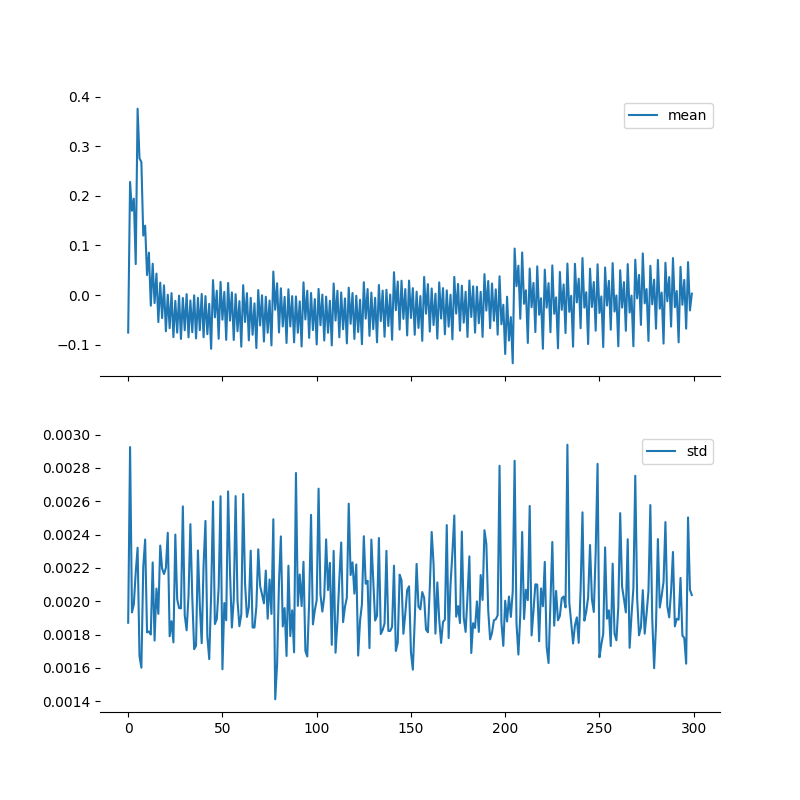

In [33]:
traces, stats, logs = analysis_for_nop_mul

limit = len(traces)

trace_mean = np.mean(traces[:limit], axis=0)
trace_std = np.std(traces[:limit], axis=0)
trace_max = np.max(traces[:limit], axis=0)
trace_min = np.min(traces[:limit], axis=0)

upper = np.max(trace_max)
lower = np.min(trace_min)

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8,8))

for ax, (trace, label) in zip(axs, [
        (trace_mean, 'mean'),
        (trace_std, 'std'),
    ]):
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.set_ylim([lower, upper])

    ax.plot(trace, label=label)

    ax.legend()
    

plt.show()

# LDI

I can try to see if different values into a register, with a simple operation like ``ldi`` can be distinct based on the value

In [34]:
s_ldi = Session('ldi', {_: 'NOP=1 LDI=%d' % ((1 << _) - 1) for _ in range(9)})

In [35]:
traces_ldi = s_ldi.capture()


XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1825 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40       	sbci	r25, 0x0

  0%|          | 0/100 [00:00<?, ?it/s]

<ipython-input-21-0189f981fda6>:109: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.array((np.array(traces), stats_from_traces(traces), disassembly))



XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1825 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40       	sbci	r25, 0x0

  0%|          | 0/100 [00:00<?, ?it/s]


XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1825 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40       	sbci	r25, 0x0

  0%|          | 0/100 [00:00<?, ?it/s]


XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1825 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40       	sbci	r25, 0x0

  0%|          | 0/100 [00:00<?, ?it/s]


XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1825 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40       	sbci	r25, 0x0

  0%|          | 0/100 [00:00<?, ?it/s]


XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1825 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40       	sbci	r25, 0x0

  0%|          | 0/100 [00:00<?, ?it/s]


XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1825 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40       	sbci	r25, 0x0

  0%|          | 0/100 [00:00<?, ?it/s]


XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1825 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40       	sbci	r25, 0x0

  0%|          | 0/100 [00:00<?, ?it/s]


XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1825 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40       	sbci	r25, 0x0

  0%|          | 0/100 [00:00<?, ?it/s]

INFO:Session:saving data at 'sessions/ldi.npy'


In [36]:
def plot_hamming(traces_hamming, limits=None, colormap_name='tab20b', instructions=[]):
    plt.figure(figsize=(10, 5))

    for weight, (trace, stats, _) in traces_hamming.items():
        plt.plot(stats[0], label=str(weight))

    plt.grid()
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

    if limits is not None:
        xlim, ylim = limits
        plt.xlim(xlim)
        plt.ylim(ylim)

    plt.legend()

    offset = 0
    
    n = len(instructions)
    cm = plt.get_cmap(colormap_name)
    colors = cm.colors
    
    for index, (instruction, duration) in enumerate(instructions):
        start = offset
        end = offset + duration * 4
        plt.axvspan(start, end, alpha=.5, color=colors[index % cm.N])
        
        plt.text(start + duration * 2, -1 + .2, instruction, rotation=90)
        
        offset = end
    
    plt.show()

In [37]:
cm = plt.get_cmap('Set1')
cm.colors

((0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (1.0, 1.0, 0.2),
 (0.6509803921568628, 0.33725490196078434, 0.1568627450980392),
 (0.9686274509803922, 0.5058823529411764, 0.7490196078431373),
 (0.6, 0.6, 0.6))

In [38]:
print(traces_ldi[0][2])

000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40       	sbci	r25, 0x00	; 0
 6d8:	e1 f7       	brne	.-8      	; 0x6d2 <main+0x32>
 6da:	00 c0       	rj

In [39]:
instrs = [
    ('sts 0x0605, r24', 1),
    ('nop', 1),
    ('nop', 1),
    ('nop', 1),
    ('nop', 1),
    ('nop', 1),
    ('nop', 1),
    ('nop', 1),
    ('nop', 1),
    ('nop', 1),
    ('nop', 1),
    ('ldi r16, <value>', 1),
    ('nop', 1),
    ('nop', 1),
    ('nop', 1),
    ('nop', 1),
    ('nop', 1),
    ('nop', 1),
    ('nop', 1),
    ('nop', 1),
    ('nop', 1),
    ('nop', 1),
    ('rjmp .-2', 2),
]

In [40]:
instrs

[('sts 0x0605, r24', 1),
 ('nop', 1),
 ('nop', 1),
 ('nop', 1),
 ('nop', 1),
 ('nop', 1),
 ('nop', 1),
 ('nop', 1),
 ('nop', 1),
 ('nop', 1),
 ('nop', 1),
 ('ldi r16, <value>', 1),
 ('nop', 1),
 ('nop', 1),
 ('nop', 1),
 ('nop', 1),
 ('nop', 1),
 ('nop', 1),
 ('nop', 1),
 ('nop', 1),
 ('nop', 1),
 ('nop', 1),
 ('rjmp .-2', 2)]

<IPython.core.display.Javascript object>


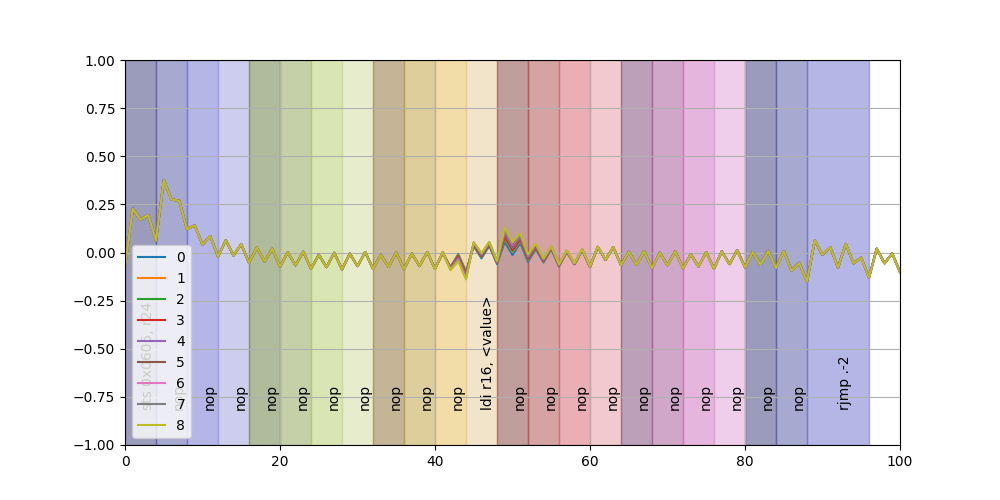

In [41]:
plot_hamming(traces_ldi, limits=([0, 100],(-1, 1)), instructions=instrs)

<IPython.core.display.Javascript object>


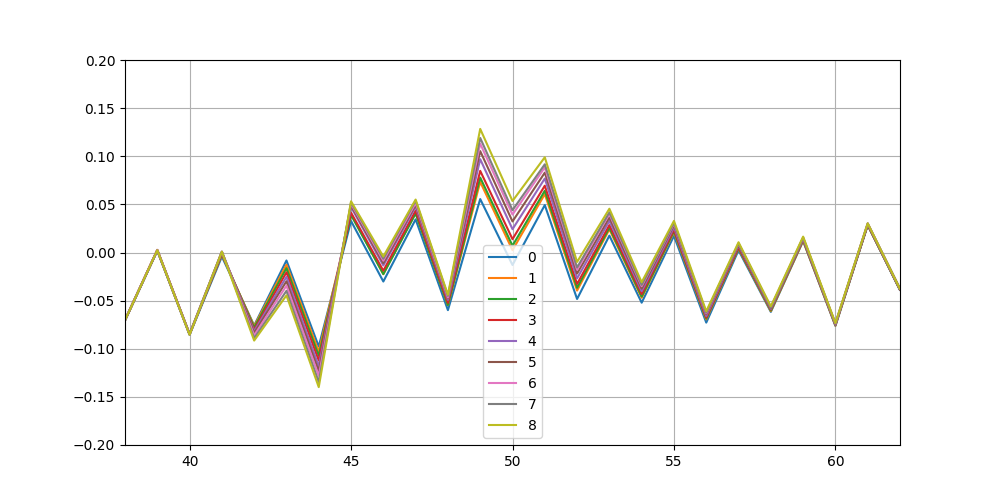

In [43]:
plt.figure(figsize=(10, 5))

for weight, (trace, stats, _) in traces_ldi.items():
    plt.plot(stats[0], label=str(weight))

plt.grid()
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

plt.xlim([38, 62])
plt.ylim([-0.2, 0.2])

plt.legend()

plt.show()

I want to see if I am able to see the pipeline in effect

In [ ]:
count = 100

options_hamming = {
    0: 'NOP=1 LDI_AFTER_JMP=0',
    1: 'NOP=1 LDI_AFTER_JMP=1',
    2: 'NOP=1 LDI_AFTER_JMP=3',
    3: 'NOP=1 LDI_AFTER_JMP=7',
    4: 'NOP=1 LDI_AFTER_JMP=15',
    5: 'NOP=1 LDI_AFTER_JMP=31',
    6: 'NOP=1 LDI_AFTER_JMP=63',
    7: 'NOP=1 LDI_AFTER_JMP=127',
    8: 'NOP=1 LDI_AFTER_JMP=255',
}

traces_ldi_jmp = {}

for weight, options in options_hamming.items():
    traces_ldi_jmp[weight] = analyze(options, count=count)

# here we have the traces in a dictionary organized in the following
#  - outer key the hamming weight
#  - each key contains a tuple (traces, stats, disassembly)

In [ ]:
plt.figure(figsize=(10, 5))

for weight, (stats, trace, _) in traces_ldi_jmp.items():
    plt.plot(stats[0], label=str(weight))

plt.grid()
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

#plt.xlim([38, 62])
#plt.ylim([-0.2, 0.2])

plt.legend()

plt.show()

In [ ]:
oh_ldi_w_jmp = {
    0: 'NOP=1 LDI_AFTER_JMP=-2 LDI=0',
    1: 'NOP=1 LDI_AFTER_JMP=-2 LDI=1',
    2: 'NOP=1 LDI_AFTER_JMP=-2 LDI=3',
    3: 'NOP=1 LDI_AFTER_JMP=-2 LDI=7',
    4: 'NOP=1 LDI_AFTER_JMP=-2 LDI=15',
    5: 'NOP=1 LDI_AFTER_JMP=-2 LDI=31',
    6: 'NOP=1 LDI_AFTER_JMP=-2 LDI=63',
    7: 'NOP=1 LDI_AFTER_JMP=-2 LDI=127',
    8: 'NOP=1 LDI_AFTER_JMP=-2 LDI=255',
}
traces_ldi_w_jmp = capture_hamming(oh_ldi_w_jmp)

In [ ]:
plot_hamming(traces_ldi_w_jmp, limits=([44, 60], [-.16, .05]))

In [44]:
s_ldi_jumped = Session('ldi_jumped', {_: 'NOP=1 LDI_AFTER_JMP=+2 LDI=%d' % ((1 << _) - 1) for _ in range(9)})

traces_ldi_jumped = s_ldi_jumped.capture()


XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1827 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40       	sbci	r25, 0x0

  0%|          | 0/100 [00:00<?, ?it/s]

<ipython-input-21-0189f981fda6>:109: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.array((np.array(traces), stats_from_traces(traces), disassembly))



XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1827 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40       	sbci	r25, 0x0

  0%|          | 0/100 [00:00<?, ?it/s]


XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1827 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40       	sbci	r25, 0x0

  0%|          | 0/100 [00:00<?, ?it/s]


XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1827 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40       	sbci	r25, 0x0

  0%|          | 0/100 [00:00<?, ?it/s]


XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1827 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40       	sbci	r25, 0x0

  0%|          | 0/100 [00:00<?, ?it/s]


XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1827 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40       	sbci	r25, 0x0

  0%|          | 0/100 [00:00<?, ?it/s]


XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1827 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40       	sbci	r25, 0x0

  0%|          | 0/100 [00:00<?, ?it/s]


XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1827 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40       	sbci	r25, 0x0

  0%|          | 0/100 [00:00<?, ?it/s]


XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1827 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40       	sbci	r25, 0x0

  0%|          | 0/100 [00:00<?, ?it/s]

INFO:Session:saving data at 'sessions/ldi_jumped.npy'


<IPython.core.display.Javascript object>


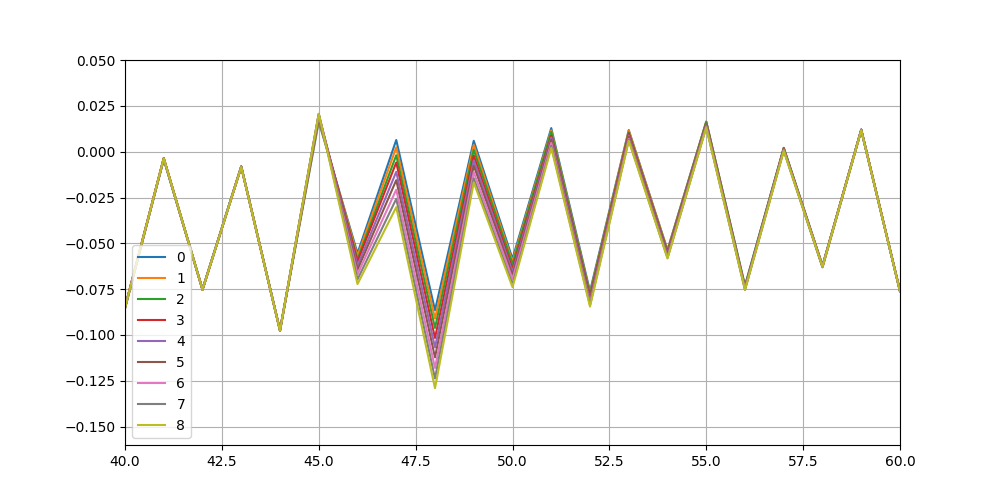

In [45]:
plot_hamming(traces_ldi_jumped, limits=([40, 60], [-.16, .05]))

In [46]:
s_adc = Session('adc', {_: 'NOP=1 SUM_A=%d SUM_B=0' % ((1 << _) - 1) for _ in range(9)})

traces_adc = s_adc.capture()


XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1829 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40       	sbci	r25, 0x0

  0%|          | 0/100 [00:00<?, ?it/s]

<ipython-input-21-0189f981fda6>:109: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.array((np.array(traces), stats_from_traces(traces), disassembly))



XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1829 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40       	sbci	r25, 0x0

  0%|          | 0/100 [00:00<?, ?it/s]


XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1829 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40       	sbci	r25, 0x0

  0%|          | 0/100 [00:00<?, ?it/s]


XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1829 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40       	sbci	r25, 0x0

  0%|          | 0/100 [00:00<?, ?it/s]


XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1829 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40       	sbci	r25, 0x0

  0%|          | 0/100 [00:00<?, ?it/s]


XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1829 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40       	sbci	r25, 0x0

  0%|          | 0/100 [00:00<?, ?it/s]


XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1829 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40       	sbci	r25, 0x0

  0%|          | 0/100 [00:00<?, ?it/s]


XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1829 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40       	sbci	r25, 0x0

  0%|          | 0/100 [00:00<?, ?it/s]


XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1829 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40       	sbci	r25, 0x0

  0%|          | 0/100 [00:00<?, ?it/s]

INFO:Session:saving data at 'sessions/adc.npy'


<ipython-input-36-2a95d7e2f291>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10, 5))


<IPython.core.display.Javascript object>


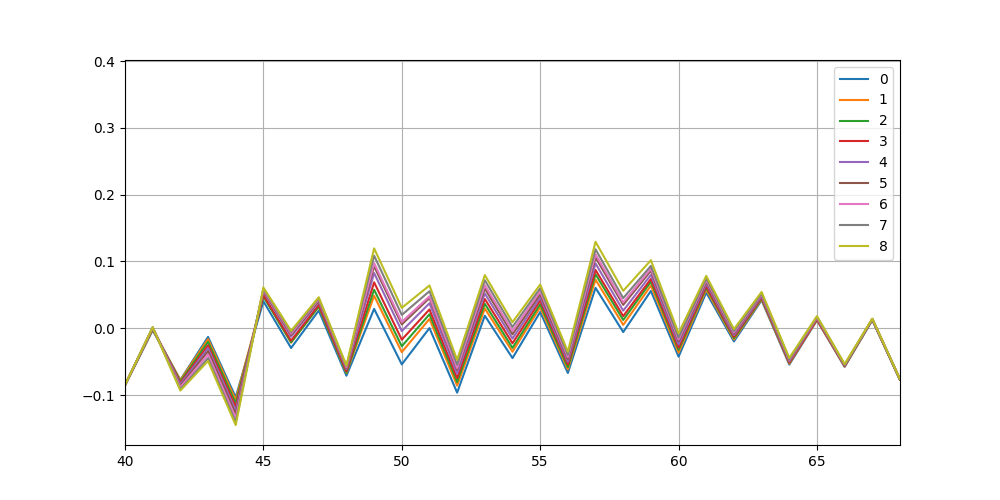

In [47]:
plot_hamming(traces_adc, limits=([40, 68], None))

In [48]:
options_hamming = {
        0: 'NOP=1 ADC_AFTER_JMP=-2 SUM_A=0 SUM_B=0',
        1: 'NOP=1 ADC_AFTER_JMP=-2 SUM_A=0 SUM_B=1',
        2: 'NOP=1 ADC_AFTER_JMP=-2 SUM_A=0 SUM_B=3',
        3: 'NOP=1 ADC_AFTER_JMP=-2 SUM_A=0 SUM_B=7',
        4: 'NOP=1 ADC_AFTER_JMP=-2 SUM_A=0 SUM_B=15',
        5: 'NOP=1 ADC_AFTER_JMP=-2 SUM_A=0 SUM_B=31',
        6: 'NOP=1 ADC_AFTER_JMP=-2 SUM_A=0 SUM_B=63',
        7: 'NOP=1 ADC_AFTER_JMP=-2 SUM_A=0 SUM_B=127',
        8: 'NOP=1 ADC_AFTER_JMP=-2 SUM_A=0 SUM_B=255',
    }
traces_adc_w_rjmp = Session('adc w rjmp', options_hamming).capture()


XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1831 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40       	sbci	r25, 0x0

  0%|          | 0/100 [00:00<?, ?it/s]

<ipython-input-21-0189f981fda6>:109: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.array((np.array(traces), stats_from_traces(traces), disassembly))



XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1831 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40       	sbci	r25, 0x0

  0%|          | 0/100 [00:00<?, ?it/s]


XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1831 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40       	sbci	r25, 0x0

  0%|          | 0/100 [00:00<?, ?it/s]


XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1831 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40       	sbci	r25, 0x0

  0%|          | 0/100 [00:00<?, ?it/s]


XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1831 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40       	sbci	r25, 0x0

  0%|          | 0/100 [00:00<?, ?it/s]


XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1831 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40       	sbci	r25, 0x0

  0%|          | 0/100 [00:00<?, ?it/s]


XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1831 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40       	sbci	r25, 0x0

  0%|          | 0/100 [00:00<?, ?it/s]


XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1831 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40       	sbci	r25, 0x0

  0%|          | 0/100 [00:00<?, ?it/s]


XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1831 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40       	sbci	r25, 0x0

  0%|          | 0/100 [00:00<?, ?it/s]

INFO:Session:saving data at 'sessions/adc_w_rjmp.npy'


<IPython.core.display.Javascript object>


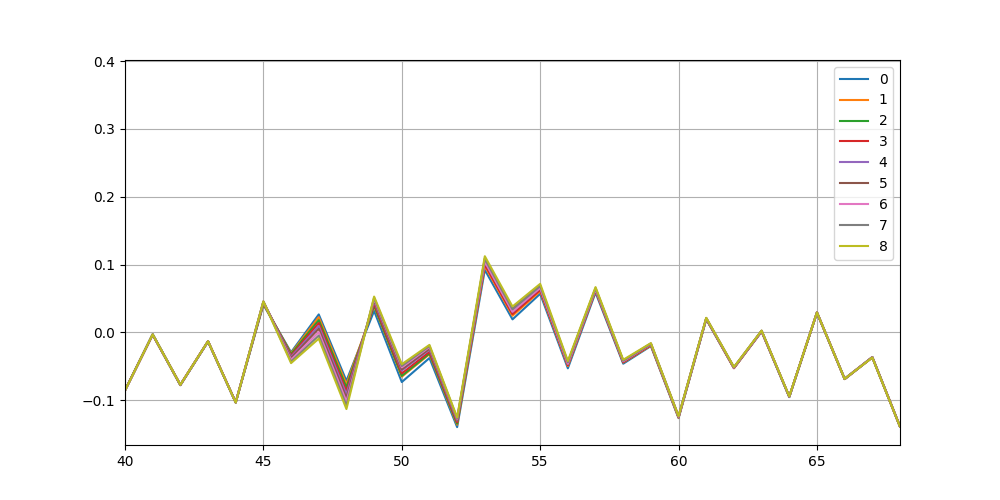

In [49]:
plot_hamming(traces_adc_w_rjmp, limits=([40, 68], None))

In [52]:
oh_adc_jumped = {
        0: 'NOP=1 ADC_AFTER_JMP=+2 SUM_A=0 SUM_B=0',
        1: 'NOP=1 ADC_AFTER_JMP=+2 SUM_A=0 SUM_B=1',
        2: 'NOP=1 ADC_AFTER_JMP=+2 SUM_A=0 SUM_B=3',
        3: 'NOP=1 ADC_AFTER_JMP=+2 SUM_A=0 SUM_B=7',
        4: 'NOP=1 ADC_AFTER_JMP=+2 SUM_A=0 SUM_B=15',
        5: 'NOP=1 ADC_AFTER_JMP=+2 SUM_A=0 SUM_B=31',
        6: 'NOP=1 ADC_AFTER_JMP=+2 SUM_A=0 SUM_B=63',
        7: 'NOP=1 ADC_AFTER_JMP=+2 SUM_A=0 SUM_B=127',
        8: 'NOP=1 ADC_AFTER_JMP=+2 SUM_A=0 SUM_B=255',
    }
traces_adc_jumped = Session('adc jumped', oh_adc_jumped).capture()


XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1831 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40       	sbci	r25, 0x0

  0%|          | 0/100 [00:00<?, ?it/s]

<ipython-input-21-0189f981fda6>:109: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.array((np.array(traces), stats_from_traces(traces), disassembly))



XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1831 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40       	sbci	r25, 0x0

  0%|          | 0/100 [00:00<?, ?it/s]


XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1831 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40       	sbci	r25, 0x0

  0%|          | 0/100 [00:00<?, ?it/s]


XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1831 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40       	sbci	r25, 0x0

  0%|          | 0/100 [00:00<?, ?it/s]


XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1831 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40       	sbci	r25, 0x0

  0%|          | 0/100 [00:00<?, ?it/s]


XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1831 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40       	sbci	r25, 0x0

  0%|          | 0/100 [00:00<?, ?it/s]


XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1831 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40       	sbci	r25, 0x0

  0%|          | 0/100 [00:00<?, ?it/s]


XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1831 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40       	sbci	r25, 0x0

  0%|          | 0/100 [00:00<?, ?it/s]


XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1831 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40       	sbci	r25, 0x0

  0%|          | 0/100 [00:00<?, ?it/s]

INFO:Session:saving data at 'sessions/adc_jumped.npy'


<IPython.core.display.Javascript object>


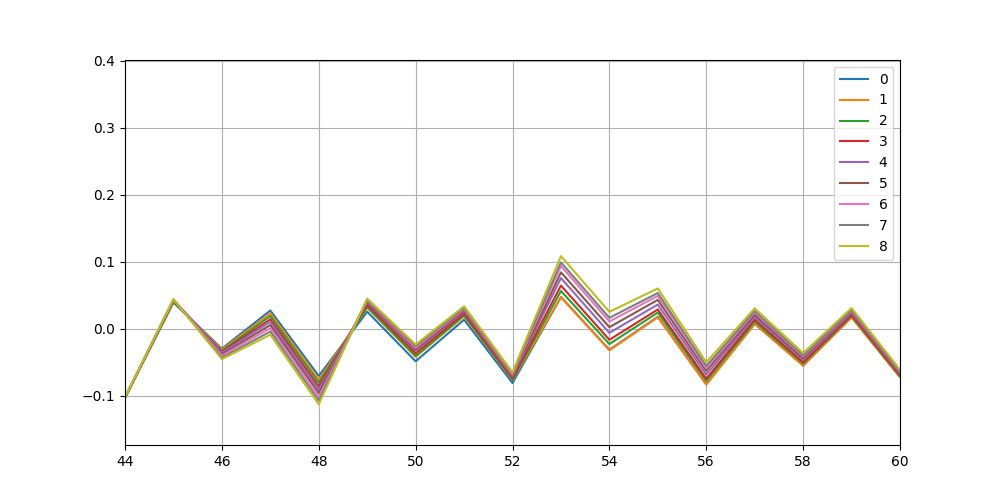

In [53]:
plot_hamming(traces_adc_jumped, limits=([44, 60], None))

I'm going to analyze how behaves ``adc`` with overflow

In [54]:
oh_adc_overflow = {_: 'NOP=1 SUM_A=1 SUM_B=%d' % ((1 << _) - 1) for _ in range(9)}
traces_adc_overflow = Session('adc overflow', oh_adc_overflow).capture()


XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1829 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40       	sbci	r25, 0x0

  0%|          | 0/100 [00:00<?, ?it/s]

<ipython-input-21-0189f981fda6>:109: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.array((np.array(traces), stats_from_traces(traces), disassembly))



XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1829 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40       	sbci	r25, 0x0

  0%|          | 0/100 [00:00<?, ?it/s]


XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1829 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40       	sbci	r25, 0x0

  0%|          | 0/100 [00:00<?, ?it/s]


XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1829 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40       	sbci	r25, 0x0

  0%|          | 0/100 [00:00<?, ?it/s]


XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1829 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40       	sbci	r25, 0x0

  0%|          | 0/100 [00:00<?, ?it/s]


XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1829 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40       	sbci	r25, 0x0

  0%|          | 0/100 [00:00<?, ?it/s]


XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1829 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40       	sbci	r25, 0x0

  0%|          | 0/100 [00:00<?, ?it/s]


XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1829 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40       	sbci	r25, 0x0

  0%|          | 0/100 [00:00<?, ?it/s]


XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 1829 bytes
000006a0 <main>:
 6a0:	0e 94 3a 03 	call	0x674	; 0x674 <platform_init>
 6a4:	0e 94 69 02 	call	0x4d2	; 0x4d2 <init_uart0>
 6a8:	c1 e0       	ldi	r28, 0x01	; 1
 6aa:	c0 93 01 06 	sts	0x0601, r28	; 0x800601 <__TEXT_REGION_LENGTH__+0x7de601>
 6ae:	88 e6       	ldi	r24, 0x68	; 104
 6b0:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6b4:	85 e6       	ldi	r24, 0x65	; 101
 6b6:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6ba:	8c e6       	ldi	r24, 0x6C	; 108
 6bc:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c0:	8c e6       	ldi	r24, 0x6C	; 108
 6c2:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6c6:	8f e6       	ldi	r24, 0x6F	; 111
 6c8:	0e 94 a6 02 	call	0x54c	; 0x54c <output_ch_0>
 6cc:	2f ef       	ldi	r18, 0xFF	; 255
 6ce:	8f e7       	ldi	r24, 0x7F	; 127
 6d0:	90 e7       	ldi	r25, 0x70	; 112
 6d2:	21 50       	subi	r18, 0x01	; 1
 6d4:	80 40       	sbci	r24, 0x00	; 0
 6d6:	90 40       	sbci	r25, 0x0

  0%|          | 0/100 [00:00<?, ?it/s]

INFO:Session:saving data at 'sessions/adc_overflow.npy'


<IPython.core.display.Javascript object>


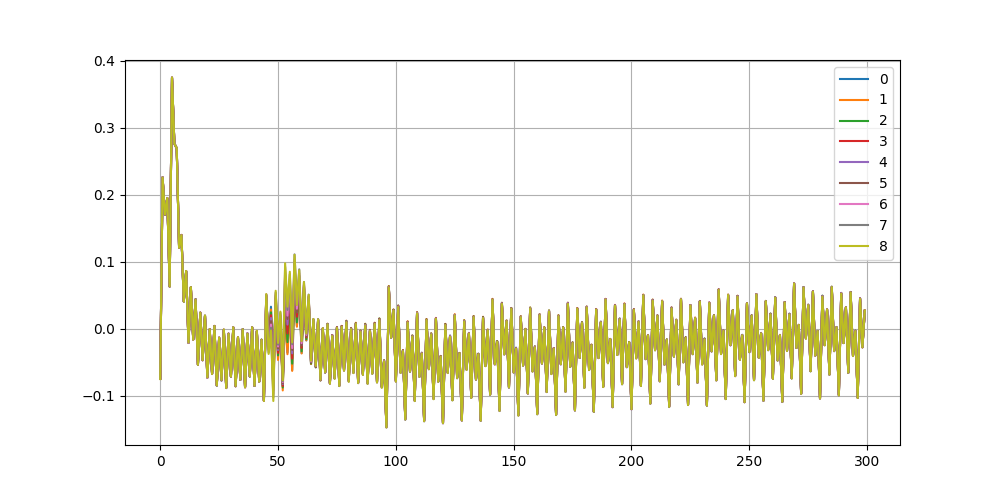

In [55]:
plot_hamming(traces_adc_overflow)

In [ ]:
oh_ldi_1st_op = {_: 'NOP=1 ADC_AFTER_JMP=+2 SUM_A=%d SUM_B=0' % ((1 << _) - 1) for _ in range(9)}

traces_ldi_1st_op = capture_hamming(oh_ldi_1st_op)

In [ ]:
plot_hamming(traces_ldi_1st_op, limits=([44, 60], [-.16, .05]))

In [ ]:
stats = np.array([_[1] for _ in traces_hamming])
stats.shape == (9, 4, 300)

In [ ]:
plt.figure()

plt.title('Relation between current and Hamming weight\n of the value of the argument of LDI')
plt.xlabel('Hamming weight')
plt.grid(linestyle=':')
# plt.errorbar(list(range(0, 9)), traces_hamming[:, 0, 49], yerr=traces_hamming[..., 1, 49], fmt='.')
plt.errorbar(list(range(0, 9)), stats[:,0, 49], yerr=stats[:,1, 49], fmt='.')

plt.show()

## LDI&ADC

now I'll try something different

```text
6d8:	10 e0       	ldi	r17, 0x00	; 0
6da:	?? e0       	ldi	r16, 0x??	; value hardcoded
6dc:	01 1f       	adc	r16, r17
```

In [ ]:
traces_adc = []

for value in [((1 << _) - 1) for _ in range(9)]:
    traces, stats, dis = analyze("NOP=1 SUM_A=0 SUM_B=%d" % value, count=100)
    traces_adc.append(stats)

traces_adc = np.array(traces_adc)

In [ ]:
np.save("sessions/adc", traces_adc)

now we can visualize the average of the traces grouped by Hamming weight, first (TODO) an overview of all the capture and after a zoom around the point where the traces differ the most 

In [ ]:
plt.figure(figsize=(10,5))

for idx, (mean, std, _, _) in enumerate(traces_adc):
    plt.plot(mean, label='%d' % ((1 << idx) - 1))


plt.legend()
plt.show()

In [ ]:
traces_hamming.shape

In [ ]:
traces_adc.shape

In [ ]:
len(traces_adc)

In [ ]:
traces_adc[:,0, 57]

we can also look specifically at the index to show the correlation in detail

In [ ]:
def plot_scatter(stats, index):
    if len(stats.shape) != 3 or stats.shape[1] != 4:
        raise ValueError("shape for `stats` must be (x, 4, y)")
    plt.figure()

    plt.title('Relation between current and value into the register at clock offset %d' % index)
    plt.xlabel('Hamming weight')
    plt.grid(linestyle=':')
    plt.errorbar(list(range(0, len(stats))), stats[:,0, index], yerr=stats[:,1, index], fmt='.')

    plt.show()

In [ ]:
plot_scatter(traces_adc, 57)

In [ ]:
plot_scatter(traces_adc, 48)

In [ ]:
plot_scatter(traces_adc, 44)

I want to try to reverse the operands to see if is at 44 that it is going to load the value in this case

In [ ]:
traces_adc_reversed = []

for value in [((1 << _) - 1) for _ in range(9)]:
    traces, stats = analyze("NOP=1 SUM_B=0 SUM_A=%d" % value, count=5)
    traces_adc_reversed.append(stats)

traces_adc_reversed = np.array(traces_adc_reversed)

In [ ]:
plot_scatter(traces_adc_reversed, 44)

In [ ]:
plot_scatter(traces_adc_reversed, 68)

In [ ]:
def plot_correlations(stats, title, start, count=10):
    fig, axs = plt.subplots(nrows=count, ncols=4, sharex='all', figsize=(10, 10))
    
    plt.subplots_adjust(wspace=.5, hspace=.6)
    # start = 36

    offset = 0
    
    n_weights = len(stats)
    

    
    for row in axs:
        for col in row:
            col.set_title(str(start + offset))
            col.grid(linestyle=':')
            # col.set_ylim([-0.150, 0.150])
            col.errorbar(
                list(range(0, n_weights)),
                stats[:,0, start + offset],
                yerr=stats[:,1, start + offset], fmt='.')
            col.set_xticks(list(range(n_weights)))
            offset += 1
        
    position_middle_title = (fig.subplotpars.right + fig.subplotpars.left)/2
    fig.suptitle(title, ha='left', x=position_middle_title)
    
    fig.show()

In [ ]:
plot_correlations(traces_adc, "ldi r17, 0\nldi r16, value\nadc r16, r17", 40, count=16)

In [ ]:
plot_correlations(traces_adc_reversed, "ldi r17, value\nldi r16, 0\nadc r16, r17", 36)

In [ ]:
def analyze_for_SUM_B_1(count=5):
    analysis = []

    for value in [((1 << _) - 1) for _ in range(9)]:
        traces, stats = analyze("NOP=1 SUM_B=1 SUM_A=%d" % value, count=count)
        analysis.append(stats)

    return np.array(analysis)

In [ ]:
stats_sum_b_1 = analyze_for_SUM_B_1()

In [ ]:
plot_correlations(stats_sum_b_1, "ldi r17, value\nldi r16, 1\nadc r16, r17", 36)

Now that I found a useful analysis to do, let me create a function to accomplish the same

In [ ]:
def analyze_hamming(options, count=5):
    analysis = []

    for value in [((1 << _) - 1) for _ in range(9)]:
        traces, stats = analyze(options % value, count=count)
        analysis.append(stats)

    return np.array(analysis)

In [ ]:
stats_w_mov = analyze_hamming("NOP=1 FINAL_MOV=1 SUM_B=1 SUM_A=%d")

In [ ]:
plot_correlations(stats_w_mov, "ldi r17, value\nldi r16, 1\nadc r16, r17\nmov r7, r16", 36)

In [ ]:
def analyze_hamming_bis(options, delta=1, count=5):
    analysis = []
    tracess = []

    for value in [((1 << _) - delta) for _ in range(9)]:
        traces, stats = analyze(options % value, count=count)
        tracess.append(traces)
        analysis.append(stats)

    return np.array(tracess), np.array(analysis)

In [ ]:
traces_w_mov2, stats_w_mov2 = analyze_hamming_bis("NOP=1 FINAL_MOV=1 SUM_B=1 SUM_A=%d", delta=2)

In [ ]:
plot_correlations(stats_w_mov2, "ldi r17, value\nldi r16, 1\nadc r16, r17\nmov r7, r16", 36)

In [ ]:
def calc_hamming_weight(n):
    return bin(n).count("1")

HW = [0]*256

for idx in range(256):
    HW[idx] = calc_hamming_weight(idx)

In [ ]:
def mean(X):
    return np.mean(X, axis=0)

def std_dev(X, X_bar):
    return np.sqrt(np.sum((X-X_bar)**2, axis=0))

def cov(X, X_bar, Y, Y_bar):
    return np.sum((X-X_bar)*(Y.reshape(X.shape[0], 1)-Y_bar), axis=0)

def correlation_traces(traces, inputs, trace_avg, trace_stddev):
    hws = np.array([[HW[aes_internal(textin[bnum], key_guess)] for textin in texts]]).transpose()
    hws_avg = mean(hws)
    
    return cov(traces, trace_avg, hws, hws_avg)/trace_stddev/std_dev(hws, hws_avg)

In [ ]:
def _corr(fmt_options, delta=1, count=10):
    traces = []
    values = []
    
    n_weights = 9

    for idx, value in enumerate([((1 << _) - delta) for _ in range(n_weights)]):
        traces_for_weight, _ = analyze(fmt_options % value, count=count)
        
        values.extend([idx] * count)
        traces.extend(traces_for_weight)
        
    return np.array(traces), np.array(values)

def __corr(traces, values):
    traces_mean = np.mean(traces, axis=0)
    traces_std = std_dev(traces, traces_mean)
    
    values_mean = np.mean(values, axis=0)
    values_std = std_dev(values, values_mean)
    
    return cov(traces, traces_mean, values, values_mean)/traces_std/values_std

def corr(*args, **kwargs):
    traces, values = _corr(*args, **kwargs)
    
    return __corr(traces, values)

In [ ]:
c = corr("NOP=1 FINAL_MOV=1 SUM_B=1 SUM_A=%d", delta=2, count=50)

In [ ]:
plt.figure()

plt.plot(c)

plt.show()

In [ ]:
c = __corr(corr_[0], corr_[1])

In [ ]:
c.shape

In [ ]:
corr_[1].shape
traces, values = corr_
traces_mean = np.mean(traces, axis=0)
traces_std = std_dev(traces, traces_mean)

values_mean = np.mean(values, axis=0)
values_std = std_dev(values, values_mean)

In [ ]:
values.reshape(9, 1).shape

In [ ]:
(traces - traces_mean)*(values.reshape(traces.shape[0], 1) - values_mean)

In [ ]:
cov(traces, traces_mean, values, values_mean)/traces_std/values_std

In [ ]:
correlation_w_mov2 = np.apply_along_axis(np.corrcoef, 0, traces_w_mov2[:,1,:], list(range(9)))
plt.figure()

plt.plot(correlation_w_mov2[1, 0])

plt.show()

In [ ]:
correlation_w_mov2.shape

## LDI improvements
Now I want to try to fetch random values and see if for real the ``ldi`` is following the hamming weight law for arbitrary values (in the previous experiments I have only used values in the form of ``(1 << v) - 1``.

To do this new challenge I created a firmware with a jump table, it's possible to activate it via the ``USE_TABLE`` definition.

In [ ]:
firmware_compile('USE_TABLE=1')
firmware_disassembly(path_fw, "main")
firmware_disassembly(path_fw, "_jt")
firmware_disassembly(path_fw, "_end_jt")

now just to check all is working right, we can upload it

In [ ]:
upload()

scope.default_setup()

and test if the jump table is working correctly

In [ ]:
for _ in trange(512):
    target.flush()
    reset_target(scope)

    data = target.read()
    print(f'{repr(data)}', end=' ')

    time.sleep(.5)

    inp = random.randbytes(1)
    target.write(inp)

    print(f"{inp=}", end=' ')

    time.sleep(.5)

    while target.in_waiting() == 0:
        pass

    output = target.read().encode('iso-8859-1')

    assert output == inp

    print(f'{output}')

In [ ]:
import random
import logging
import os
import sys

logging.basicConfig(
    format='%(asctime)s [%(levelname)s] %(name)s - %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
    stream=sys.stdout,
)


class BaseExperiment:
    """Class to wrap scope, target and save captured traces."""
    
    PATH_SESSIONS = "sessions"
    FW_DIS_FUNCTIONS = []

    def __init__(self, name, _scope, _target, project, options=None):
        self.name = self.slugify(name)
        self.project = project
        self.scope = _scope
        self.target = _target
        self.options = options or ""
        self.results = {_:list() for _ in range(9)}
        
        self.logger = logging.getLogger(self.__class__.__name__)
        self.logger.setLevel('DEBUG')
        
        self.path_fw = None
        
        self._setup_scope()
        self._setup_target()
        
    def _setup_scope(self):
        self.scope.default_setup()
        self.scope.adc.samples = 500
        self.scope.adc.timeout = 5000

    def get_firmware_path(self, ext):
        """Return the firmware HEX file from the project name."""
        return PATH_CW / "hardware/victims/firmware/{project}/{project}-{platform}.{ext}".format(
            project=self.project, platform=PLATFORM, ext=ext)

    def firmware_compile(self):
        p = subprocess.run(
            'cp -rv {project} {path_cw}/hardware/victims/firmware/ && cd {path_cw}/hardware/victims/firmware/{project} && LANG=C make PLATFORM={platform} {options} CRYPTO_TARGET=NONE'.format(
                project=self.project,
                platform=PLATFORM,
                path_cw=PATH_CW,
                options=self.options,
            ),
            capture_output=True,
            shell=True)
        print(p.stdout.decode('utf-8')[:-100])
        print(p.stderr.decode('utf-8'))
        p.check_returncode()
    
        return self.get_firmware_path('hex')

    def upload(self):
        cw.program_target(
            self.scope,
            prog,
            str(self.path_fw))

    def firmware_disassembly(self, name_function):
        fw = self.get_firmware_path('elf')
        p = subprocess.run(
            "avr-objdump  -D --disassemble-zeroes {fw} | sed -n '/<{name}>:/,/^$/p'".format(fw=fw, name=name_function),
            capture_output=True,
            shell=True)
        stdout = p.stdout.decode('utf-8')

        print(stdout)
        print(p.stderr.decode('utf-8'))

        return stdout

    def _setup_target(self):
        self.path_fw = self.firmware_compile()
        for name in self.FW_DIS_FUNCTIONS:
            self.firmware_disassembly(name)

        self.upload()

    @staticmethod
    def slugify(label: str):
        return label.translate(str.maketrans("/ ;", "___"))
        
    @classmethod
    def get_sessions(cls):
        """Return the previous sessions"""
        if not os.path.exists(cls.PATH_SESSIONS):
            raise Exception("you must create the `sessions` directory")
            
        dirpath, dirnames, filenames = next(os.walk(cls.PATH_SESSIONS))
        return dirnames
    
    def get_path(self):
        return '{}.npy'.format(os.path.join(self.PATH_SESSIONS, self.name))
    
    def get_trace(self):
        """Try to retrieve traces for this session from the filesystem."""
        path = self.get_path()
        
        if not os.path.exists(path):
            return None
        
        self.logger.info("loading trace found at '{}'".format(path))
        
        return np.load(path, allow_pickle=True)[()]
    
    def normalize_trace(self, trace):
        """The values coming from the ADC must be inverted"""
        return -trace
    
    def save_traces(self, data):
        path = self.get_path()
        self.logger.info("saving data at '{}'".format(path))
        np.save(path, data)

    def random_bytes(self, count) -> bytes:
        return random.randbytes(count)
    
    def reboot_flush(self):            
        #Flush garbage too
        self.target.flush()
        self.scope.io.pdic = False
        time.sleep(0.1)
        self.scope.io.pdic = "high_z"
        time.sleep(0.1)

    def single_capture(self, input_value: bytes, with_trace=True):
        # remember to reset
        self.reboot_flush()
        # and then arm otherwise
        # the scope will trigger
        # during the reset itself
        scope.arm()
        
        self.target.write(input_value)
        
        trace = None
        is_captured = False
        if with_trace:
            is_captured = self.scope.capture()

        data = self.target.read()

        trace = self.scope.get_last_trace()
    
        return self.normalize_trace(trace), data.encode("iso-8859-1")  # in this way I don't get weird unicode artefacts for 0x80
    
    def run(self, **kwargs):
        cache = self.get_trace()
        
        if cache is not None:
            self.logger.info('using cache')
            self.results = cache
            
            return

        self.logger.info("-- Starting session")

        self.do_run(**kwargs)
        
        self.save_traces(self.results)


class Experiment(BaseExperiment):
    def random_input(self, weight: int) -> bytes:
        """This function is necessary in order to generate a uniform distribution
        with regards to hamming weights otherwise element with weight zero
        and eight are particularly under-represented."""
        
        table = [
            [b'\x00'],
            [bytes([   1 << _]) for _ in range(8)],
            [bytes([(  3 << _) & 0xff]) for _ in range(7)],
            [bytes([(  7 << _) & 0xff]) for _ in range(6)],
            [bytes([( 15 << _) & 0xff]) for _ in range(5)],
            [bytes([( 31 << _) & 0xff]) for _ in range(4)],
            [bytes([( 63 << _) & 0xff]) for _ in range(3)],
            [bytes([(127 << _) & 0xff]) for _ in range(2)],
            [bytes([(255 << _) & 0xff]) for _ in range(1)],
        ]
        
        return random.choice(table[weight])

    def do_run(self, count=100):
        for weight in trange(9):
            for _ in trange(count):
                input_value = self.random_input(weight)
                trace, output = self.single_capture(input_value)

                hw = calc_hamming_weight(int.from_bytes(input_value, 'little'))
                self.results[hw].append(trace)


In [ ]:
exp = Experiment('jump table', scope, target)

In [ ]:
exp.run()

In [ ]:
[(_, len(exp.results[_])) for _ in exp.results.keys()]

In [ ]:
plt.figure(figsize=(10, 5))

for weight, traces in exp.results.items():
    if len(traces) == 0:
        continue
    mean, std, mn, mx = stats_from_traces(traces)

    plt.plot(mean, label=str(weight))

plt.grid()
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    
plt.legend()
plt.show()

## Constant time

Now I'll try something more useful to apply what I discovered

In [ ]:
class ConstantTimeExperiment(BaseExperiment):
    FW_DIS_FUNCTIONS = ["main"]
    def do_run(self, count=100):
        results = []
        
        for _ in trange(count):
            inp = self.random_bytes(5)
            traces, output = self.single_capture(inp + b'\n')
            results.append((traces, inp))
            
        self.results['data'] = np.array(results)

In [ ]:
ct = ConstantTimeExperiment('constant time', scope, target, 'simpleserial-constant-time')

In [ ]:
trace, output = ct.single_capture("geo\n")

print(output)

plt.figure(figsize=(10, 5))

plt.plot(trace)

plt.show()

In [ ]:
ct.run(count=5000)

In [ ]:
[HW[_[1][0]] for _ in ct.results['data']]

In [ ]:
np.array([_[0] for _ in ct.results['data']])

In [ ]:
plt.figure(figsize=(10, 5))

plt.plot(ct.results['data'][0][0])
plt.plot(stats_from_traces(np.array([_[0] for _ in ct.results['data']]))[0])
plt.show()

In [ ]:
from typing import Tuple, Iterable
import logging
from scipy.stats import pearsonr


class Correlation:
    """Calculate correlation between traces and hamming weight of the inputs
    (or a tranformation of it)."""
    def __init__(self, data: Iterable[Tuple[bytes, np.array]], logging_level='INFO'):
        self.data = data
        
        self.logger = logging.getLogger(self.__class__.__name__)
        self.logger.setLevel(logging_level)
        
    def pearson_for(self, key, index):
        """Return the correlation between hamming weight of the
        XOR of `key` with the input that generated the trace and
        the trace itself."""
        
        hamming_input = np.array([HW[inp[index]^int.from_bytes(key, 'little')] for _, inp in self.data])
        traces = np.array([trace for trace, _ in self.data])
        
        self.logger.debug(f"{hamming_input.shape=} {traces.shape=}")
        
        # here we are going to generate a vertical slice
        # of correlation
        rows, columns = traces.shape
        
        assert traces.shape[0] == hamming_input.shape[0]

        result = []
        
        for column in range(columns):
            vertical = [traces[row][column] for row in range(rows)]
        
            pearson = pearsonr(hamming_input, vertical)
            
            result.append(pearson[0])
        
            self.logger.debug(f"{pearson=}")
            
        result = np.array(result)
        
        self.logger.debug(f"{result.shape=}")
        
        return result
    
    def best(self, index):
        result = []
        
        for key in trange(1, 256):  # remove the null byte to avoid input correlation
            result.append(np.max(self.pearson_for(bytes([key]), index)))
            
        return np.argmax(result)

In [ ]:
c = Correlation(ct.results['data'])

In [ ]:
correlation = c.pearson_for(b'\x00', 0)

In [ ]:
def plot_correlation_for(corr, key, index, instructions={}):
    correlation = corr.pearson_for(key, index)
    plt.figure(figsize=(10, 5))

    plt.ylim([-1, 1])
    
    bbox = {'fc': '0.8'}
    
    offset = 0
    
    for instruction, duration in instructions:
        start = offset
        end = offset + duration * 4
        plt.axvspan(start, end, alpha=.5)
        
        plt.text(start + duration * 2, -1 + .2, instruction, rotation=90)
        
        offset = end
    
    plt.plot(correlation)

    plt.show()

In [ ]:
instructions = [
    ('movw r30, r16', 1),
    ('movw r18, r28', 1),
    ('subi r18, 0xFA', 1),
    ('sbci r19, 0xFF', 1),
    ('ldi r24, 0x00', 1),
    ('movw r26, r14', 1),
    ('ld r20, X+', 2),
    ('movw r14, r26', 1),
    ('ld r25, Z+', 2),
    ('eor r25, r20', 1),
    ('or r24, r25', 1),
    ('cp r26, r18', 1),
    ('cpc r27, r19', 1),
    ('brne .-18', 2),
    ('movw r26, r14', 1),
    ('ld r20, X+', 2),
    ('movw r14, r26', 1),
    ('ld r25, Z+', 2),
    ('eor r25, r20', 1),
    ('or r24, r25', 1),
    ('cp r26, r18', 1),
    ('cpc r27, r19', 1),
    ('brne .-18', 2),

]

In [ ]:
plot_correlation_for(c, b'\x00', 0, instructions)

In [ ]:
plot_correlation_for(c, b'\x00', 1)

In [ ]:
plot_correlation_for(c, b'\x00', 2)

In [ ]:
plot_correlation_for(c, b'\x00', 3)

In [ ]:
plot_correlation_for(c, b'k', 0)

In [ ]:
plot_correlation_for(c, b'\x02', 0)

In [ ]:
c.best(0)

In [ ]:
scope.dis()
target.dis()